In [2]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange
import networkx as nx
import math
import seaborn as sns

model_path = "data/graph_task/attention_only_nodes7_k2_p0.40_d256_4layers_1heads/model.pt"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = torch.load(model_path)

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_74015/2457720587.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [4]:
def edge_to_str(edge):
    return chr(edge[0] + ord('a')) + chr(edge[1] + ord('a')) + "."

def edge_context(edges):
    return "".join([edge_to_str(edge) for edge in edges])

def query(n1, n2):
    return chr(n1 + ord('a')) + chr(n2 + ord('a')) + "?"

def max_question_length(n_nodes):
    return len(generate_question(nx.connected_watts_strogatz_graph(n_nodes, k=2, p=0))[0])

def generate_question(G, n1=None, n2=None):
    assert n1 is None or n1 in G.nodes, "n1 is not a node in the graph"
    assert n2 is None or n2 in G.nodes, "n2 is not a node in the graph"
    
    if n1 is None and n2 is None:
        n1, n2 = np.random.choice(list(G.nodes), replace=False, size=2)
    else:
        assert n1 != n2, "n1 and n2 are the same node"
        if n1 is None:
            n1 = np.random.choice(list(G.nodes))
        if n2 is None:
            n2 = np.random.choice(list(G.nodes))
    try: 
        answer = nx.shortest_path_length(G, n1, n2)
    except nx.NetworkXNoPath:
        answer = -1
    edges = list(G.edges)
    return edge_context(edges) + query(n1, n2), answer

def create_token_map(n_nodes):
    token_map = {}
    for i in range(n_nodes):
        token_map[i] = i
    for i in range(n_nodes):
        token_map[chr(i + ord('a'))] = i + n_nodes 

    token_map["."] = 2*n_nodes
    token_map["-"] = 2*n_nodes + 1
    token_map["?"] = 2*n_nodes + 2
    token_map["pad"] = 2*n_nodes + 3
    token_map[-1] = 2*n_nodes + 4
    return token_map

def tokenize(input_str, token_map):
    return torch.tensor([token_map[c] for c in input_str])

from torch.utils.data import Dataset, DataLoader
from itertools import permutations, combinations
class graphDataset(Dataset):
    def __init__(self, n_nodes, n_graphs, train_test_split=0.75, k=2, p=0.4):
        self.n_nodes = n_nodes
        self.p = p        
        self.k = k
        self.train_test_split = train_test_split
        self.token_map = create_token_map(n_nodes)
        self.inverse_map = {v:k for k, v in self.token_map.items()}
        self.n_tokens = len(self.token_map)
        self.max_length = max_question_length(n_nodes)
        
        self.X = torch.zeros(n_graphs, self.max_length, dtype=torch.long)
        self.y = torch.zeros(n_graphs, dtype=torch.long)

        for i in range(n_graphs):
            g = self._generate_graph()
            self.X[i], self.y[i] = self._generate_question_(g)

        self.n_samples = n_graphs
        self.n_train = int(self.n_samples*self.train_test_split)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)

    def _generate_question_(self, G, n1=None, n2=None):
            q, a = generate_question(G, n1, n2)
            q, a = tokenize(q, self.token_map), torch.tensor(self.token_map[a])
            return (q, a)
    
    def _generate_graph(self):
        g = nx.connected_watts_strogatz_graph(self.n_nodes, k=self.k, p=self.p)
        g.edges = np.random.permutation([np.random.permutation(edge) for edge in g.edges])    
        return g
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return 

    def generate_batch_new(self, batch_size, type='train'):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        
        question_pairs = np.random.permutation(list(permutations(range(5), 2)))
        n_pairs = len(question_pairs)
        X = torch.zeros(n_pairs*batch_size, self.max_length, dtype=torch.long)
        y = torch.zeros(n_pairs*batch_size, dtype=torch.long)
        
        for j in range(batch_size):
            g = nx.connected_watts_strogatz_graph(self.n_nodes, k=self.k, p=self.p)
            g.edges = np.random.permutation([np.random.permutation(edge) for edge in g.edges])    
            for i in range(n_pairs):
                X[j*n_pairs + i, ...], y[j*n_pairs + i] = self._generate_question_(g, question_pairs[i][0], question_pairs[i][1])
        return X, y

    def generate_batch(self, batch_size, type='train'):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        assert type in ['train', 'test'], "type must be either 'train' or 'test'"

        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [5]:
import einops
def concat_attn(attn):
    cat_attn = torch.cat([a.unsqueeze(0) for a in attn], dim=0)
    return einops.rearrange(cat_attn, 'l b ... -> b l ...')

def apply_triu_mask(im, k = 1):
    mask = np.ones_like(im)
    triu_mask = np.triu_indices_from(mask, k=k)
    im[triu_mask] = np.nan
    return im

In [37]:
data = graphDataset(5, 100000, k=2, p=0.4)

In [38]:
samp = 0
def get_same_token_scores(question_batch, attn_batch, n_layers=4):
    n_samp = attn_batch.shape[0]
    same_token_scores = np.empty((n_samp, 2, n_layers))
    for samp in range(n_samp):
        for layer in range(n_layers):
            q_np = question_batch[samp].detach().numpy()
            attn_np = attn_batch[samp, layer, 0, :, :].detach().numpy()
            same_tokens_idx = apply_triu_mask(np.array(q_np.reshape(-1, 1) == q_np.reshape(1, -1), dtype = float), k = 0)

            grammar_idx = (q_np == 10)
            grammar_mat = grammar_idx.reshape(-1, 1) | grammar_idx.reshape(1, -1)
            grammar_mat = apply_triu_mask(np.array(grammar_mat, dtype=float), k=0)

            question_idx = np.zeros(18, dtype=bool)
            question_idx[-3:] = True
            question_idx = question_idx.reshape(-1, 1) | question_idx.reshape(1, -1)
            question_idx = apply_triu_mask(np.array(question_idx, dtype=float), k=0)


            same_token_scores_samp = attn_np[(same_tokens_idx == 1) & (grammar_mat == 0) & (question_idx == 0)]
            other_token_scores_samp = attn_np[(same_tokens_idx == 0) & (grammar_mat == 0) & (question_idx == 0)]

            same_token_scores[samp, :, layer] = np.array([same_token_scores_samp.mean(), other_token_scores_samp.mean()])
    return same_token_scores



In [58]:
logits

tensor([[ -2.7267,  -7.7001,  12.6090,  ...,  -3.7178,  -1.4466,  -3.7182],
        [ -2.8908,  -5.8096,  11.5498,  ...,  -3.1944,  -1.7081,  -3.4325],
        [ -2.9786, -11.1464,  11.9306,  ...,  -4.6421,  -1.4631,  -3.9401],
        ...,
        [ -1.6029,  23.0350,   9.5641,  ...,  -0.8197,  -2.6036,  -0.8898],
        [ -2.2565,  22.5402,  12.6956,  ...,  -1.4768,  -2.8736,  -1.5789],
        [ -2.3917,  15.4727,   7.3627,  ...,  -2.8148,  -2.7837,  -1.7312]],
       grad_fn=<SliceBackward0>)

In [59]:
logits.argmax(-1)

tensor([2, 2, 3,  ..., 1, 1, 1])

In [60]:
question_batch, answer_batch = data.generate_batch(5000, type='test')
logits, attn_batch = model.forward_with_weights(question_batch)
attn_batch = concat_attn(attn_batch)

def accuracy(logits, answers):
    return (logits.argmax(-1) == answers).float().mean()

accuracy(logits, answer_batch)

tensor(0.9808)

In [61]:
out = get_same_token_scores(question_batch, attn_batch)

(array([49929.,     0.,     0.,     0.,     0., 38906.,     0.,     0.,
            0., 11165.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

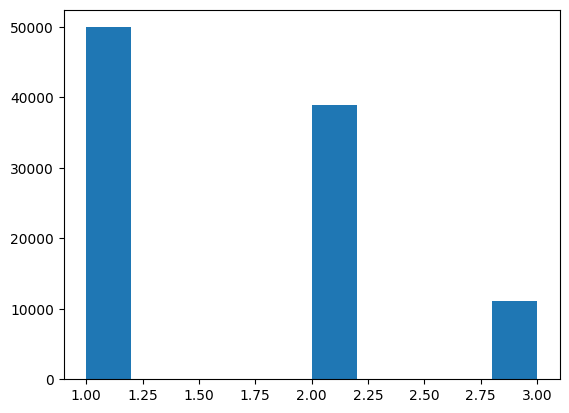

In [144]:
plt.hist(data.y)

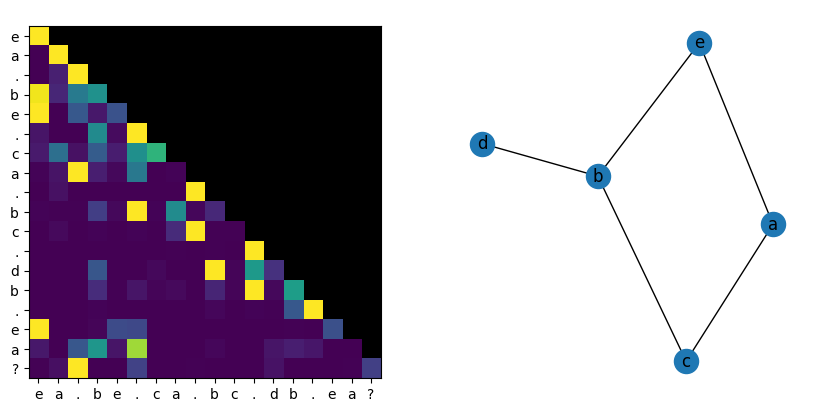

In [141]:

def plot_attn(ax, question, attn, vmax=0.5):
    ticks = [data.inverse_map[q] for q in question.detach().numpy()]
    im = apply_triu_mask(attn.detach().numpy())
    cmap = plt.cm.viridis
    cmap.set_bad(color='black')
    im = ax.imshow(im, cmap=cmap, vmax=vmax)
    ax.set_xticks(range(len(ticks)), ticks)
    ax.set_yticks(range(len(ticks)), ticks)
    return ax

def draw_graph_from_question(question):
    question = question.detach().numpy()
    q_str = np.array([data.inverse_map[q] for q in question])
    edges = q_str.reshape(-1, 3)[:-1, :2]
    #edges = question.detach().numpy().reshape(-1, 3)[:, :2]
    g = nx.Graph()
    g.add_edges_from(edges)
    return g

layer = 3
samp += 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_attn(ax[0], question_batch[samp], attn_batch[samp, layer, 0, :, :])
g = draw_graph_from_question(question_batch[samp])
nx.draw(g, with_labels=True, ax=ax[1])

In [107]:
question = question_batch[0].detach().numpy()


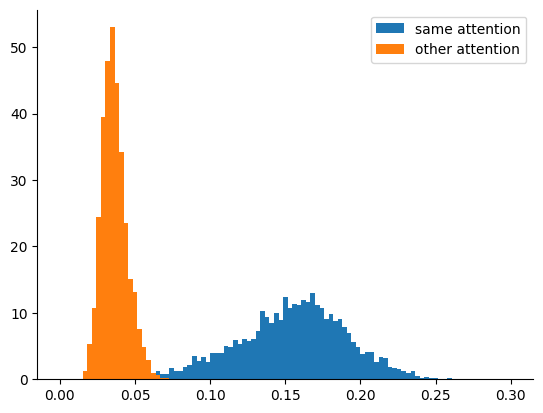

In [84]:
layer = 0
bins = np.linspace(0, 0.3, 100)
plt.hist(out[:, 0, layer], bins, label="same attention", density=True)
plt.hist(out[:, 1, layer], bins, label="other attention", density=True)
plt.legend()
sns.despine()
plt.show()